In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.options.display.max_columns = 500

In [2]:
import sidetable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, accuracy_score as accu, f1_score, matthews_corrcoef as mcc, balanced_accuracy_score as bas
from xgboost import XGBClassifier
import time

In [4]:
import tensorflow as tf

2023-09-10 10:26:51.909109: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-10 10:26:52.373502: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-10 10:26:52.375853: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 10:26:54.266871: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
cancer_dataset= pd.read_csv('./cancer.csv', lineterminator='\n',sep=',')

## Info about the data set

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.
n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server:
ftp ftp.cs.wisc.edu
cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

1) ID number
2) Diagnosis (M = malignant, B = benign)
3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)
b) texture (standard deviation of gray-scale values)
c) perimeter
d) area
e) smoothness (local variation in radius lengths)
f) compactness (perimeter^2 / area - 1.0)
g) concavity (severity of concave portions of the contour)
h) concave points (number of concave portions of the contour)
i) symmetry
j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features. For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [6]:
#!pip install pandas_profiling
#from pandas_profiling import ProfileReport
#prof = ProfileReport(cancer)
#prof.to_file(output_file='output.html')

In [7]:
def info_univariado(new_df):
  df_info = pd.DataFrame(columns=['Cantidad', 'Tipo' , 'Missing', 'Unicos', 'Numeric'])
  for col in new_df:
    data_series = new_df[col]
    df_info.loc[col] = [data_series.count(), data_series.dtype, data_series.isnull().sum(), data_series.nunique(), pd.api.types.is_numeric_dtype(data_series)]
    df_describe = new_df.describe(include='all').T[['top', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    df_stats = pd.DataFrame([new_df.skew(numeric_only=True), new_df.kurtosis(numeric_only=True)], index=['sesgo', 'kurt']).T
  return pd.concat([df_info,pd.concat([df_describe, df_stats], axis=1)], axis=1).fillna('0')

## Split

First of all, we separate the dataset between a train set and a test set, so that all analyzes and conclusions are based on our training set. We will use the test only at the end, to evaluate the final model.

In [8]:
X = cancer_dataset.drop(columns=['diagnosis'])  # Características
y = cancer_dataset['diagnosis']               # Variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=76)

For convenience, We also keep a dataframe, which we are going to call 'cancer', which is a training set including the target variable.

In [9]:
cancer=pd.concat([X_train, y_train], axis=1)

## EDA

In [10]:
cancer.shape

(455, 33)

In [11]:
cancer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 455 entries, 458 to 463
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       455 non-null    int64  
 1   radius_mean              455 non-null    float64
 2   texture_mean             455 non-null    float64
 3   perimeter_mean           455 non-null    float64
 4   area_mean                455 non-null    float64
 5   smoothness_mean          455 non-null    float64
 6   compactness_mean         455 non-null    float64
 7   concavity_mean           455 non-null    float64
 8   concave points_mean      455 non-null    float64
 9   symmetry_mean            455 non-null    float64
 10  fractal_dimension_mean   455 non-null    float64
 11  radius_se                455 non-null    float64
 12  texture_se               455 non-null    float64
 13  perimeter_se             455 non-null    float64
 14  area_se                  455 

In [12]:
cancer.duplicated().sum()

0

In [13]:
##See if there are duplicates by REMOVING the column called id.

(cancer[cancer.duplicated(subset=cancer.columns.difference(['Id']), keep=False)].sum().sum())/(cancer.shape[1])
#Divide by the number of columns to find out how many duplicate rows there are.

0.0

In [14]:
cancer.describe().T

,count,mean,std,min,25%,50%,75%,max
id,455.0,3.278056e+07,1.325178e+08,8670.000000,869221.000000,907145.000000,8.910375e+06,9.113205e+08
radius_mean,455.0,1.412846e+01,3.495331e+00,6.981000,11.750000,13.380000,1.576500e+01,2.811000e+01
texture_mean,455.0,1.934378e+01,4.345636e+00,9.710000,16.330000,18.900000,2.183000e+01,3.928000e+01
perimeter_mean,455.0,9.198791e+01,2.408855e+01,43.790000,75.380000,86.240000,1.039500e+02,1.885000e+02
area_mean,455.0,6.547231e+02,3.518774e+02,143.500000,426.650000,551.700000,7.772500e+02,2.501000e+03
smoothness_mean,455.0,9.620127e-02,1.390038e-02,0.052630,0.086390,0.095860,1.045500e-01,1.634000e-01
compactness_mean,455.0,1.042586e-01,5.166557e-02,0.023440,0.065885,0.094620,1.304500e-01,3.454000e-01
concavity_mean,455.0,8.868312e-02,7.892519e-02,0.000000,0.029975,0.061260,1.306000e-01,4.268000e-01
concave points_mean,455.0,4.842156e-02,3.797715e-02,0.000000,0.020310,0.033410,7.382000e-02,2.012000e-01
symmetry_mean,455.0,1.808677e-01,2.684259e-02,0.106000,0.162000,0.178800,1.955000e-01,2.906000e-01


In [15]:
cancer.sample(10)

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,\r,diagnosis
292,891670,12.950,16.02,83.14,513.7,0.10050,0.07943,0.061550,0.03370,0.1730,0.06470,0.2094,0.7636,1.231,17.67,0.008725,0.02003,0.023350,0.011320,0.02625,0.004726,13.74,19.93,88.81,585.4,0.14830,0.2068,0.22410,0.10560,0.3380,0.09584,NaN,B
81,8611161,13.340,15.86,86.49,520.0,0.10780,0.15350,0.116900,0.06987,0.1942,0.06902,0.2860,1.0160,1.535,12.96,0.006794,0.03575,0.039800,0.013830,0.02134,0.004603,15.53,23.19,96.66,614.9,0.15360,0.4791,0.48580,0.17080,0.3527,0.10160,NaN,B
372,9012795,21.370,15.10,141.30,1386.0,0.10010,0.15150,0.193200,0.12550,0.1973,0.06183,0.3414,1.3090,2.407,39.06,0.004426,0.02675,0.034370,0.013430,0.01675,0.004367,22.69,21.84,152.10,1535.0,0.11920,0.2840,0.40240,0.19660,0.2730,0.08666,NaN,M
342,89827,11.060,14.96,71.49,373.9,0.10330,0.09097,0.053970,0.03341,0.1776,0.06907,0.1601,0.8225,1.355,10.80,0.007416,0.01877,0.027580,0.010100,0.02348,0.002917,11.92,19.90,79.76,440.0,0.14180,0.2210,0.22990,0.10750,0.3301,0.09080,NaN,B
427,90745,10.800,21.98,68.79,359.9,0.08801,0.05743,0.036140,0.01404,0.2016,0.05977,0.3077,1.6210,2.240,20.20,0.006543,0.02148,0.029910,0.010450,0.01844,0.002690,12.76,32.04,83.69,489.5,0.13030,0.1696,0.19270,0.07485,0.2965,0.07662,NaN,B
127,866203,19.000,18.91,123.40,1138.0,0.08217,0.08028,0.092710,0.05627,0.1946,0.05044,0.6896,1.3420,5.216,81.23,0.004428,0.02731,0.040400,0.013610,0.02030,0.002686,22.32,25.73,148.20,1538.0,0.10210,0.2264,0.32070,0.12180,0.2841,0.06541,NaN,M
424,907145,9.742,19.12,61.93,289.7,0.10750,0.08333,0.008934,0.01967,0.2538,0.07029,0.6965,1.7470,4.607,43.52,0.013070,0.01885,0.006021,0.010520,0.03100,0.004225,11.21,23.17,71.79,380.9,0.13980,0.1352,0.02085,0.04589,0.3196,0.08009,NaN,B
338,897880,10.050,17.53,64.41,310.8,0.10070,0.07326,0.025110,0.01775,0.1890,0.06331,0.2619,2.0150,1.778,16.85,0.007803,0.01449,0.016900,0.008043,0.02100,0.002778,11.16,26.84,71.98,384.0,0.14020,0.1402,0.10550,0.06499,0.2894,0.07664,NaN,B
444,9110127,18.030,16.85,117.50,990.0,0.08947,0.12320,0.109000,0.06254,0.1720,0.05780,0.2986,0.5906,1.921,35.77,0.004117,0.01560,0.029750,0.009753,0.01295,0.002436,20.38,22.02,133.30,1292.0,0.12630,0.2666,0.42900,0.15350,0.2842,0.08225,NaN,M
197,877159,18.080,21.84,117.40,1024.0,0.07371,0.08642,0.110300,0.05778,0.1770,0.05340,0.6362,1.3050,4.312,76.36,0.005530,0.05296,0.061100,0.014440,0.02140,0.005036,19.76,24.70,129.10,1228.0,0.08822,0.1963,0.25350,0.09181,0.2369,0.06558,NaN,M


In [16]:
info_univariado(cancer)

,Cantidad,Tipo,Missing,Unicos,Numeric,top,mean,std,min,25%,50%,75%,max,sesgo,kurt
id,455,int64,0,455,True,0,32780562.421978,132517786.174321,8670.0,869221.0,907145.0,8910375.0,911320501.0,6.101815,37.096048
radius_mean,455,float64,0,379,True,0,14.128462,3.495331,6.981,11.75,13.38,15.765,28.11,0.993711,1.108737
texture_mean,455,float64,0,398,True,0,19.34378,4.345636,9.71,16.33,18.9,21.83,39.28,0.678618,0.994507
perimeter_mean,455,float64,0,421,True,0,91.987912,24.08855,43.79,75.38,86.24,103.95,188.5,1.035118,1.218676
area_mean,455,float64,0,430,True,0,654.723077,351.877405,143.5,426.65,551.7,777.25,2501.0,1.75539,4.305035
smoothness_mean,455,float64,0,389,True,0,0.096201,0.0139,0.05263,0.08639,0.09586,0.10455,0.1634,0.452531,1.045319
compactness_mean,455,float64,0,434,True,0,0.104259,0.051666,0.02344,0.065885,0.09462,0.13045,0.3454,1.185614,1.821283
concavity_mean,455,float64,0,430,True,0,0.088683,0.078925,0.0,0.029975,0.06126,0.1306,0.4268,1.417412,2.086706
concave points_mean,455,float64,0,433,True,0,0.048422,0.037977,0.0,0.02031,0.03341,0.07382,0.2012,1.164439,1.107139
symmetry_mean,455,float64,0,360,True,0,0.180868,0.026843,0.106,0.162,0.1788,0.1955,0.2906,0.665497,1.057485


In [17]:
cancer['diagnosis'].value_counts()

diagnosis
B    285
M    170
Name: count, dtype: int64

## Insights

* There are 10 characteristics that have 3 columns each: average value, worst value and standard deviation. They are all numerical and continuous variables.
* The target variable is diagnosis. It's not very imbalanced. There are 357 benign and 212 malignant.
* The id column should be thrown away, it is not useful information for predicting.
* The last column is named \r and has no data.

[Text(0.5, 0, 'Radio máximo de las células'), Text(0, 0.5, 'Percent')]

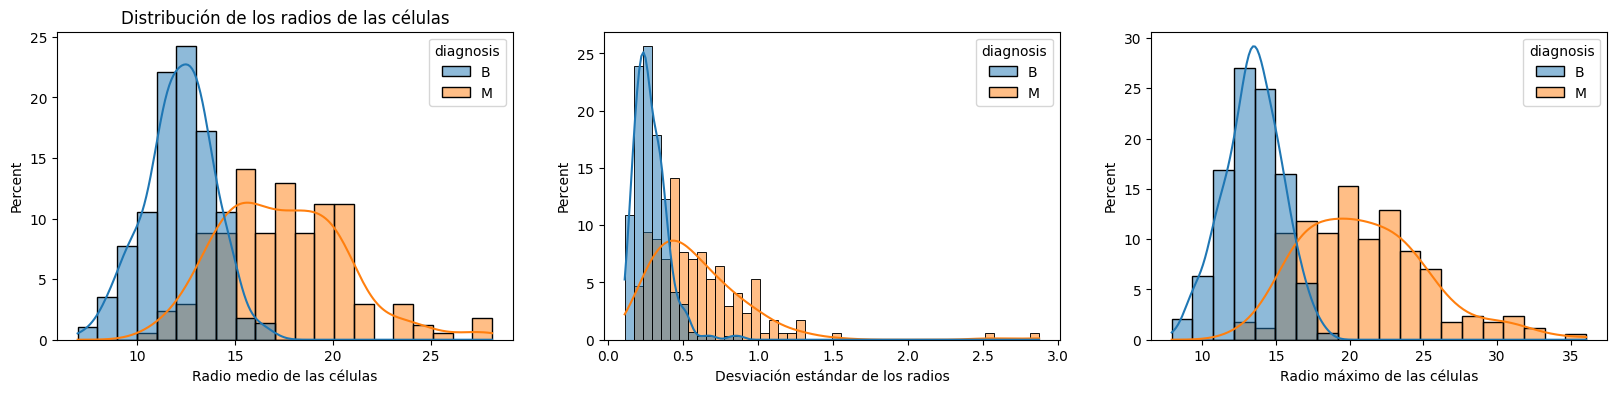

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,4))
sns.histplot(data=cancer, x='radius_mean', hue=cancer.diagnosis, kde=True, ax=ax[0],stat='percent', common_norm=False)
ax[0].set(xlabel='Radio medio de las células', ylabel='Percent')
ax[0].set_title("Distribución de los radios de las células")

sns.histplot(data=cancer, x='radius_se', hue=cancer.diagnosis, kde=True, ax=ax[1],stat='percent', common_norm=False)
ax[1].set(xlabel='Desviación estándar de los radios', ylabel='Percent')

sns.histplot(data=cancer, x='radius_worst', hue=cancer.diagnosis, kde=True, ax=ax[2],stat='percent', common_norm=False)
ax[2].set(xlabel='Radio máximo de las células', ylabel='Percent')

There is a significant difference between the distributions of benign and malignant tumors. Malignant tumors tend to be more than 5 cm larger, and the spread of their sizes is somewhat higher.

Let's see the rest of the features.

[Text(0.5, 0, 'Gris máximo de las células'), Text(0, 0.5, 'Percent')]

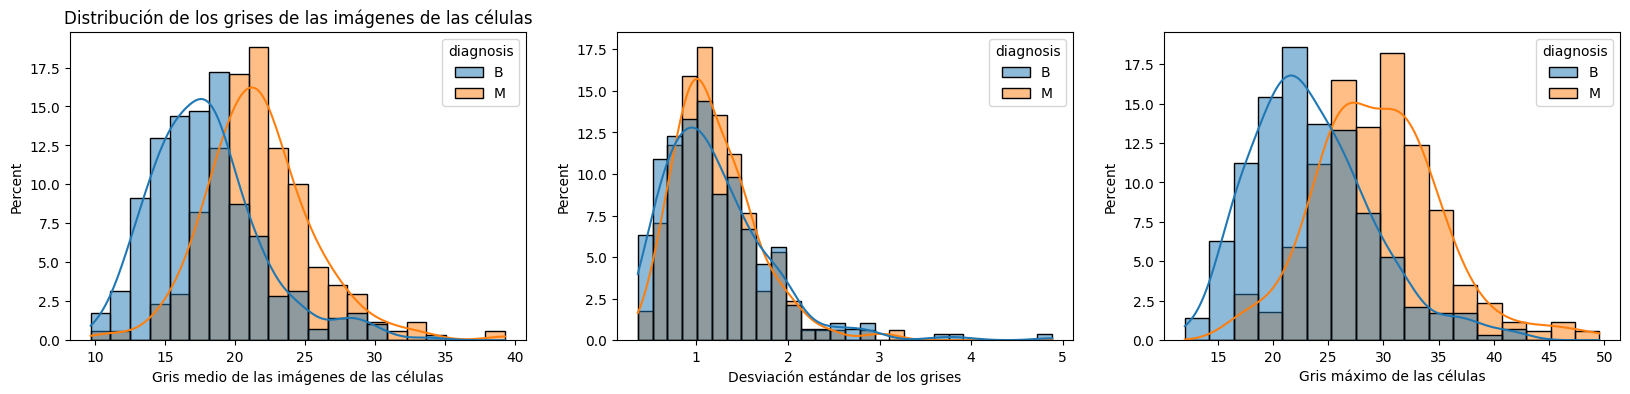

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,4))
sns.histplot(data=cancer, x='texture_mean', hue=cancer.diagnosis, kde=True, ax=ax[0],stat='percent', common_norm=False)
ax[0].set(xlabel='Gris medio de las imágenes de las células', ylabel='Percent')
ax[0].set_title("Distribución de los grises de las imágenes de las células")

sns.histplot(data=cancer, x='texture_se', hue=cancer.diagnosis, kde=True, ax=ax[1],stat='percent', common_norm=False)
ax[1].set(xlabel='Desviación estándar de los grises', ylabel='Percent')

sns.histplot(data=cancer, x='texture_worst', hue=cancer.diagnosis, kde=True, ax=ax[2],stat='percent', common_norm=False)
ax[2].set(xlabel='Gris máximo de las células', ylabel='Percent')

[Text(0.5, 0, 'Perímetro máximo de las células'), Text(0, 0.5, 'Percent')]

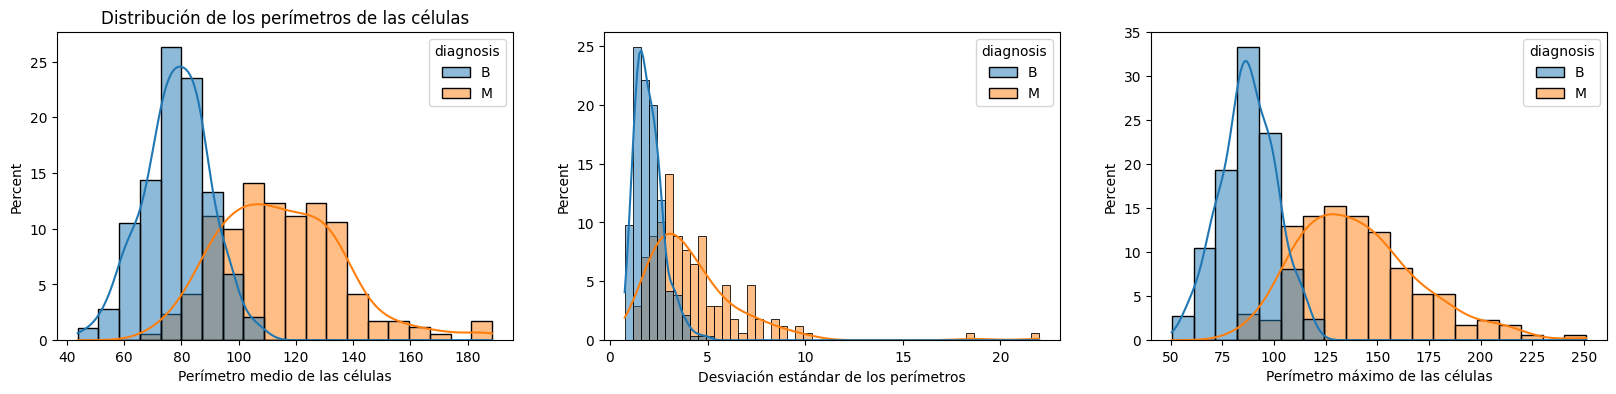

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,4))
sns.histplot(data=cancer, x='perimeter_mean', hue=cancer.diagnosis, kde=True, ax=ax[0],stat='percent', common_norm=False)
ax[0].set(xlabel='Perímetro medio de las células', ylabel='Percent')
ax[0].set_title("Distribución de los perímetros de las células")

sns.histplot(data=cancer, x='perimeter_se', hue=cancer.diagnosis, kde=True, ax=ax[1],stat='percent', common_norm=False)
ax[1].set(xlabel='Desviación estándar de los perímetros', ylabel='Percent')

sns.histplot(data=cancer, x='perimeter_worst', hue=cancer.diagnosis, kde=True, ax=ax[2],stat='percent', common_norm=False)
ax[2].set(xlabel='Perímetro máximo de las células', ylabel='Percent')

[Text(0.5, 0, 'Área máxima de las células'), Text(0, 0.5, 'Percent')]

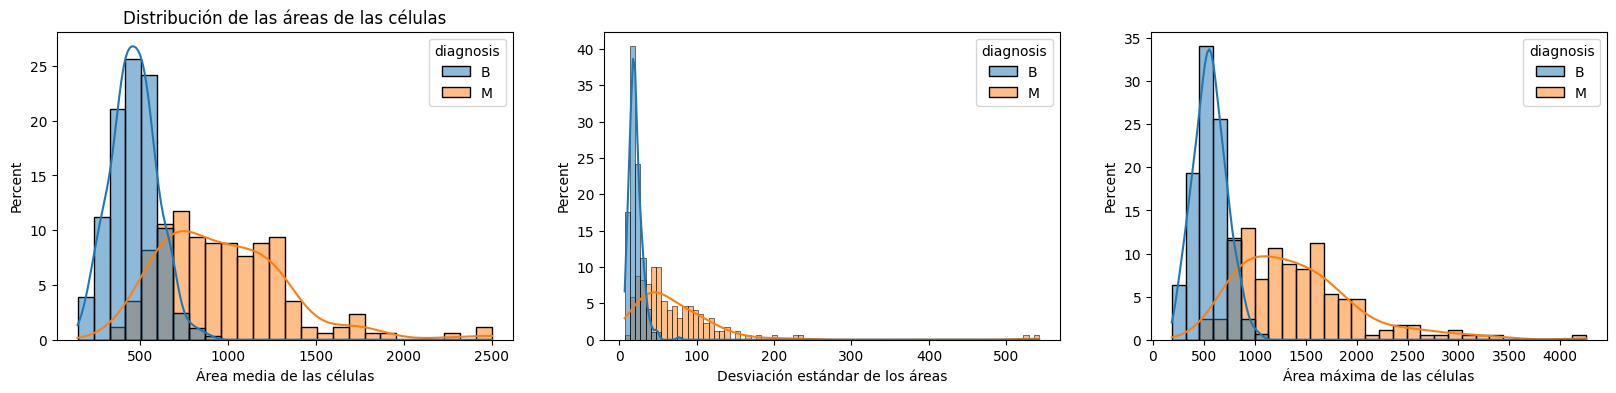

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,4))
sns.histplot(data=cancer, x='area_mean', hue=cancer.diagnosis, kde=True, ax=ax[0],stat='percent', common_norm=False)
ax[0].set(xlabel='Área media de las células', ylabel='Percent')
ax[0].set_title("Distribución de las áreas de las células")

sns.histplot(data=cancer, x='area_se', hue=cancer.diagnosis, kde=True, ax=ax[1],stat='percent', common_norm=False)
ax[1].set(xlabel='Desviación estándar de los áreas', ylabel='Percent')

sns.histplot(data=cancer, x='area_worst', hue=cancer.diagnosis, kde=True, ax=ax[2],stat='percent', common_norm=False)
ax[2].set(xlabel='Área máxima de las células', ylabel='Percent')

[Text(0.5, 0, 'Smoothness máximo'), Text(0, 0.5, 'Percent')]

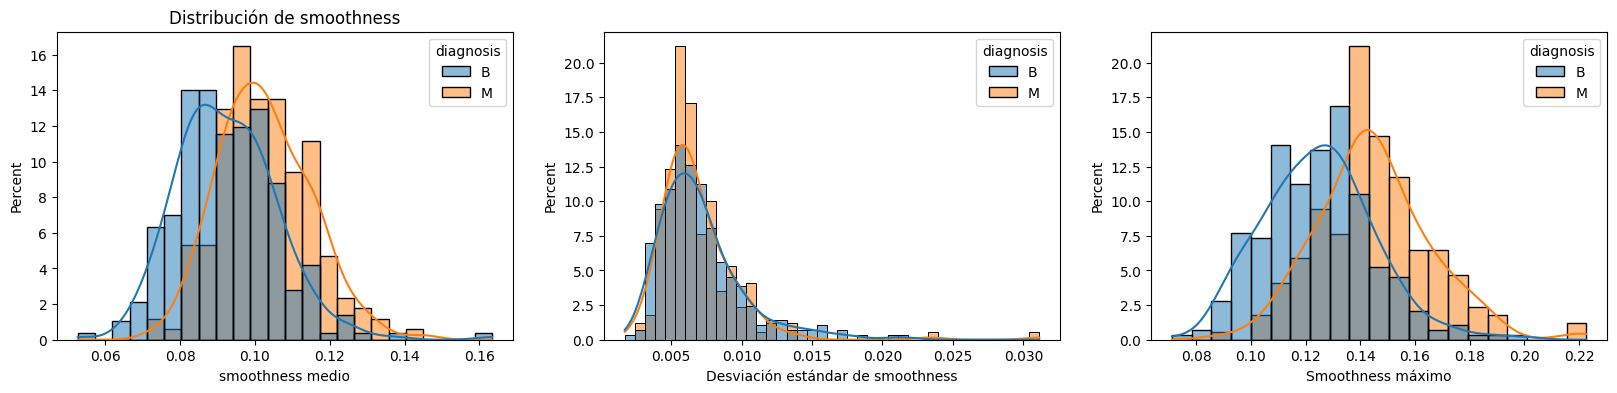

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,4))
sns.histplot(data=cancer, x='smoothness_mean', hue=cancer.diagnosis, kde=True, ax=ax[0],stat='percent', common_norm=False)
ax[0].set(xlabel='smoothness medio', ylabel='Percent')
ax[0].set_title("Distribución de smoothness")

sns.histplot(data=cancer, x='smoothness_se', hue=cancer.diagnosis, kde=True, ax=ax[1],stat='percent', common_norm=False)
ax[1].set(xlabel='Desviación estándar de smoothness', ylabel='Percent')

sns.histplot(data=cancer, x='smoothness_worst', hue=cancer.diagnosis, kde=True, ax=ax[2],stat='percent', common_norm=False)
ax[2].set(xlabel='Smoothness máximo', ylabel='Percent')

[Text(0.5, 0, 'Compactness máximo'), Text(0, 0.5, 'Percent')]

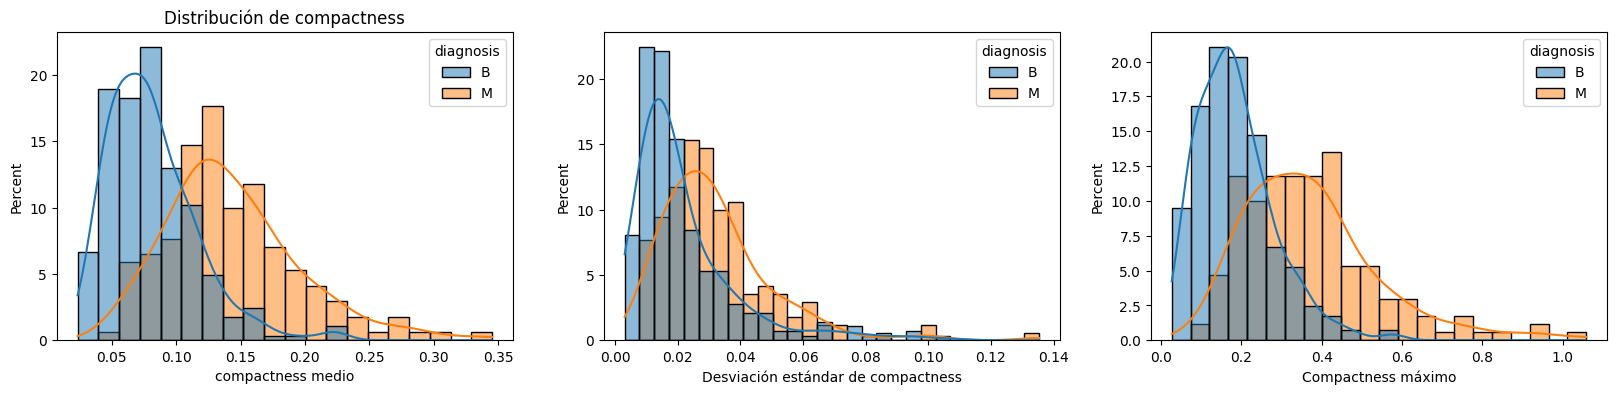

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,4))
sns.histplot(data=cancer, x='compactness_mean', hue=cancer.diagnosis, kde=True, ax=ax[0],stat='percent', common_norm=False)
ax[0].set(xlabel='compactness medio', ylabel='Percent')
ax[0].set_title('Distribución de compactness')

sns.histplot(data=cancer, x='compactness_se', hue=cancer.diagnosis, kde=True, ax=ax[1],stat='percent', common_norm=False)
ax[1].set(xlabel='Desviación estándar de compactness', ylabel='Percent')

sns.histplot(data=cancer, x='compactness_worst', hue=cancer.diagnosis, kde=True, ax=ax[2],stat='percent', common_norm=False)
ax[2].set(xlabel='Compactness máximo', ylabel='Percent')

[Text(0.5, 0, 'Concavity máximo'), Text(0, 0.5, 'Percent')]

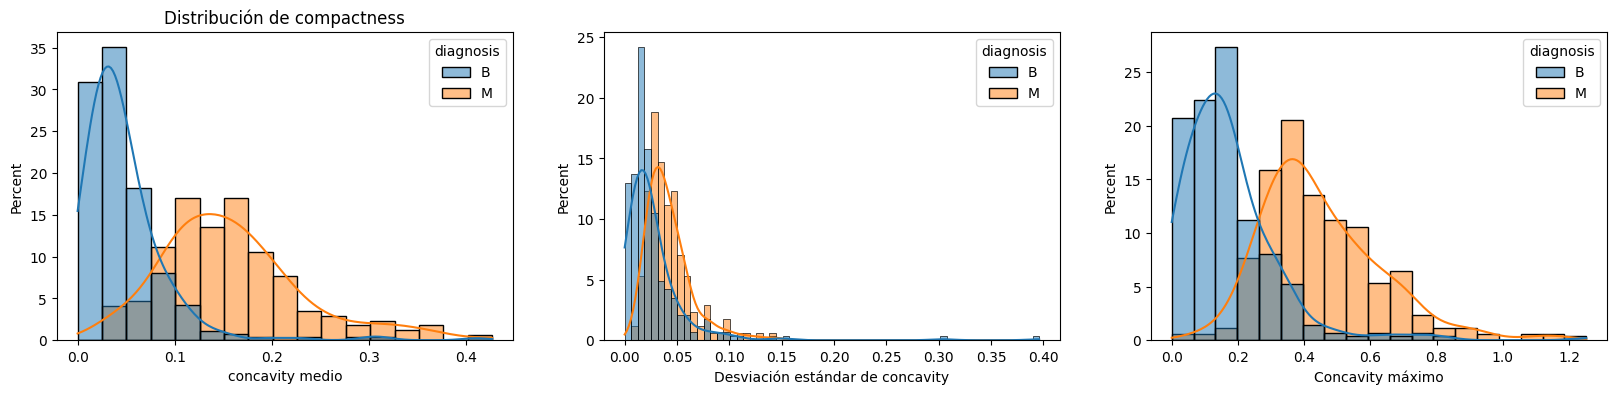

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,4))
sns.histplot(data=cancer, x='concavity_mean', hue=cancer.diagnosis, kde=True, ax=ax[0],stat='percent', common_norm=False)
ax[0].set(xlabel='concavity medio', ylabel='Percent')
ax[0].set_title('Distribución de compactness')

sns.histplot(data=cancer, x='concavity_se', hue=cancer.diagnosis, kde=True, ax=ax[1],stat='percent', common_norm=False)
ax[1].set(xlabel='Desviación estándar de concavity', ylabel='Percent')

sns.histplot(data=cancer, x='concavity_worst', hue=cancer.diagnosis, kde=True, ax=ax[2],stat='percent', common_norm=False)
ax[2].set(xlabel='Concavity máximo', ylabel='Percent')

[Text(0.5, 0, 'Concave points máximo'), Text(0, 0.5, 'Percent')]

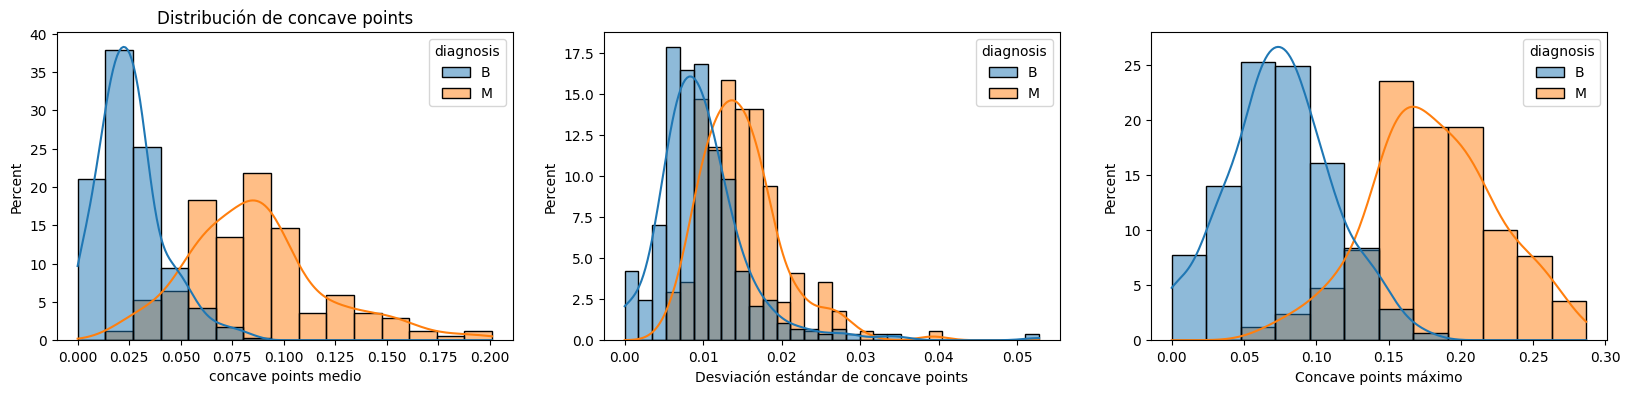

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,4))
sns.histplot(data=cancer, x='concave points_mean', hue=cancer.diagnosis, kde=True, ax=ax[0],stat='percent', common_norm=False)
ax[0].set(xlabel='concave points medio', ylabel='Percent')
ax[0].set_title('Distribución de concave points')

sns.histplot(data=cancer, x='concave points_se', hue=cancer.diagnosis, kde=True, ax=ax[1],stat='percent', common_norm=False)
ax[1].set(xlabel='Desviación estándar de concave points', ylabel='Percent')

sns.histplot(data=cancer, x='concave points_worst', hue=cancer.diagnosis, kde=True, ax=ax[2],stat='percent', common_norm=False)
ax[2].set(xlabel='Concave points máximo', ylabel='Percent')

[Text(0.5, 0, 'symmetry máximo'), Text(0, 0.5, 'Percent')]

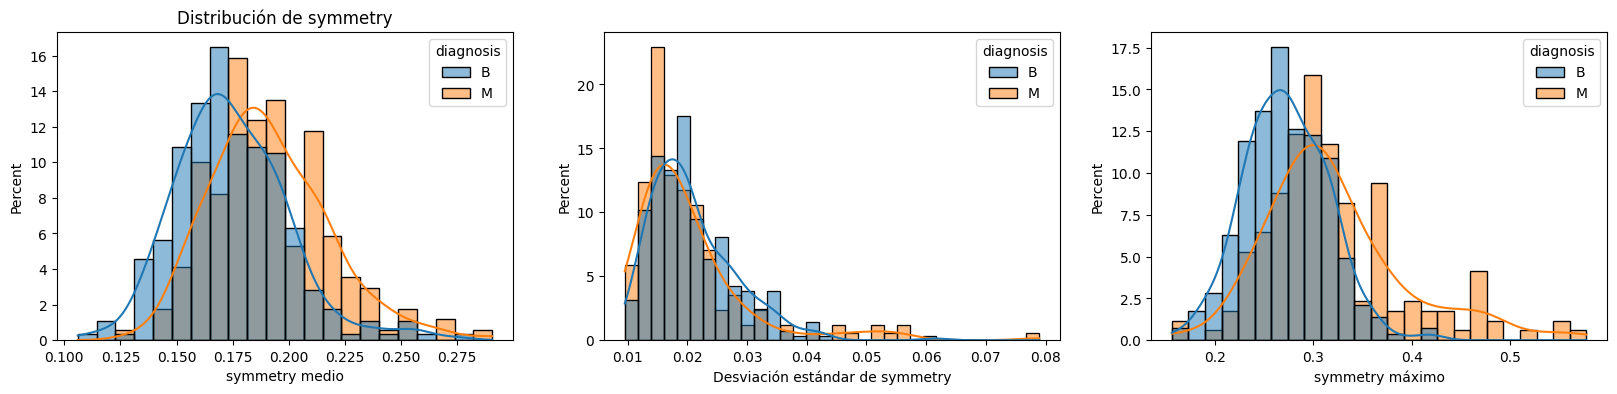

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,4))
sns.histplot(data=cancer, x='symmetry_mean', hue=cancer.diagnosis, kde=True, ax=ax[0],stat='percent', common_norm=False)
ax[0].set(xlabel='symmetry medio', ylabel='Percent')
ax[0].set_title('Distribución de symmetry')

sns.histplot(data=cancer, x='symmetry_se', hue=cancer.diagnosis, kde=True, ax=ax[1],stat='percent', common_norm=False)
ax[1].set(xlabel='Desviación estándar de symmetry', ylabel='Percent')

sns.histplot(data=cancer, x='symmetry_worst', hue=cancer.diagnosis, kde=True, ax=ax[2],stat='percent', common_norm=False)
ax[2].set(xlabel='symmetry máximo', ylabel='Percent')

[Text(0.5, 0, 'fractal_dimension máximo'), Text(0, 0.5, 'Percent')]

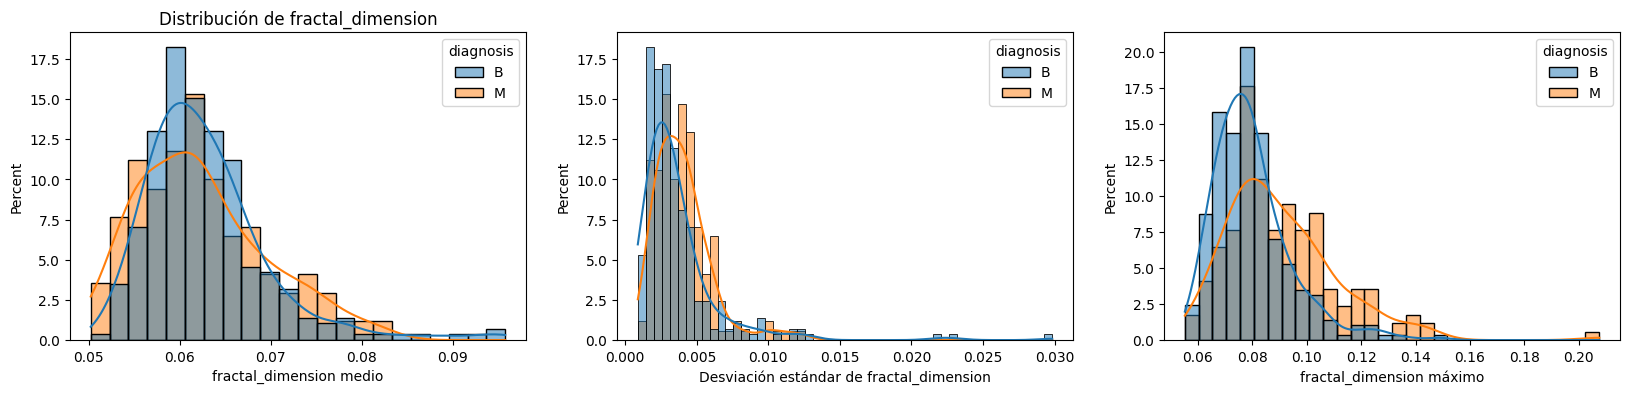

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,4))
sns.histplot(data=cancer, x='fractal_dimension_mean', hue=cancer.diagnosis, kde=True, ax=ax[0],stat='percent', common_norm=False)
ax[0].set(xlabel='fractal_dimension medio', ylabel='Percent')
ax[0].set_title('Distribución de fractal_dimension')

sns.histplot(data=cancer, x='fractal_dimension_se', hue=cancer.diagnosis, kde=True, ax=ax[1],stat='percent', common_norm=False)
ax[1].set(xlabel='Desviación estándar de fractal_dimension', ylabel='Percent')

sns.histplot(data=cancer, x='fractal_dimension_worst', hue=cancer.diagnosis, kde=True, ax=ax[2],stat='percent', common_norm=False)
ax[2].set(xlabel='fractal_dimension máximo', ylabel='Percent')

Vemos que smoothness, symmmetry y fractal_dimension son características donde no se diferencias tanto las células benignas y las malignas.

## Correlación entre variables

Veamos la correlación entre las variables. Vamos a agrupar las variables que corresponden al mismo feature en forma adyacente para que sea más claro. También pasamos a ceros y unos la columna objetivo y tiramos la columna id pues no aporta.

In [28]:
cancer.drop(columns=['id', '\r'], inplace=True)
cancer['diagnosis']=cancer['diagnosis'].map({'M': 1, 'B': 0}) 
cancer['diagnosis']=cancer['diagnosis'].astype(int)


In [29]:
cancer_sorted = cancer.sort_index(axis=1)


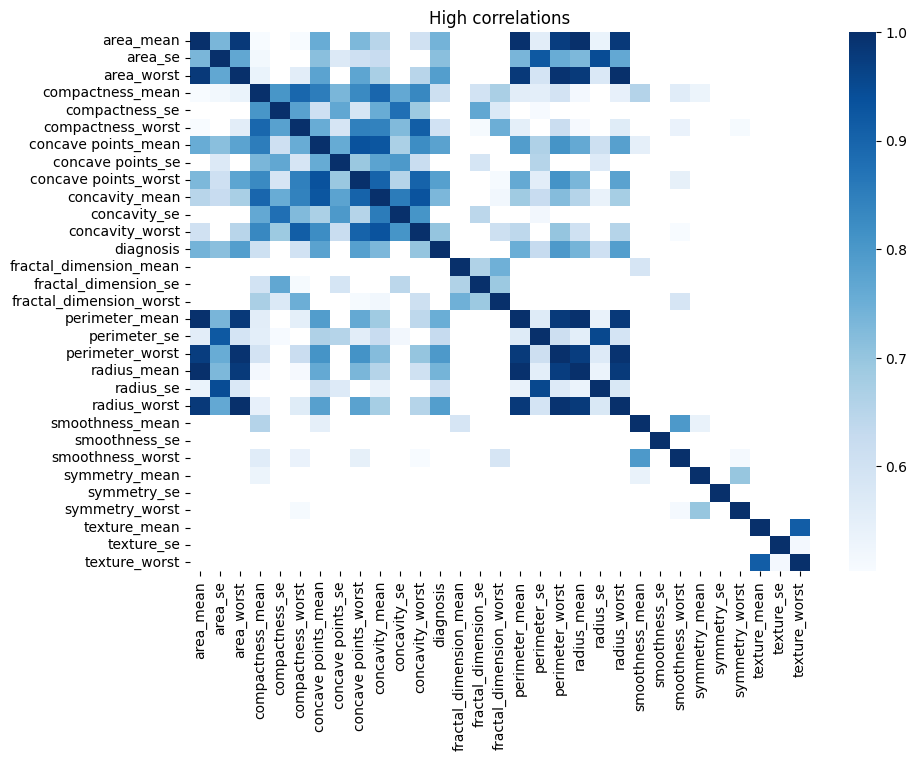

In [30]:
matrix_correlation = cancer_sorted.corr(method='spearman', numeric_only = True) 
high_corr = matrix_correlation[np.abs(matrix_correlation)>=.5] 
plt.figure(figsize=(10,7))
sns.heatmap(high_corr, cmap="Blues")
plt.title('High correlations');

We see that the mean and worst columns of each feature are always correlated. Between the mean and se columns, sometimes they present high correlation and sometimes not.

We also see high correlation between the area, perimeter and radius columns, and between the compactness, concave_points and concavity columns. Between these two groups we also see correlation.

To visualize these relationships we can also make scatterplots between the main features in pairs:

/home/tristamshandy/Python/ml/env/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x1200 with 0 Axes>

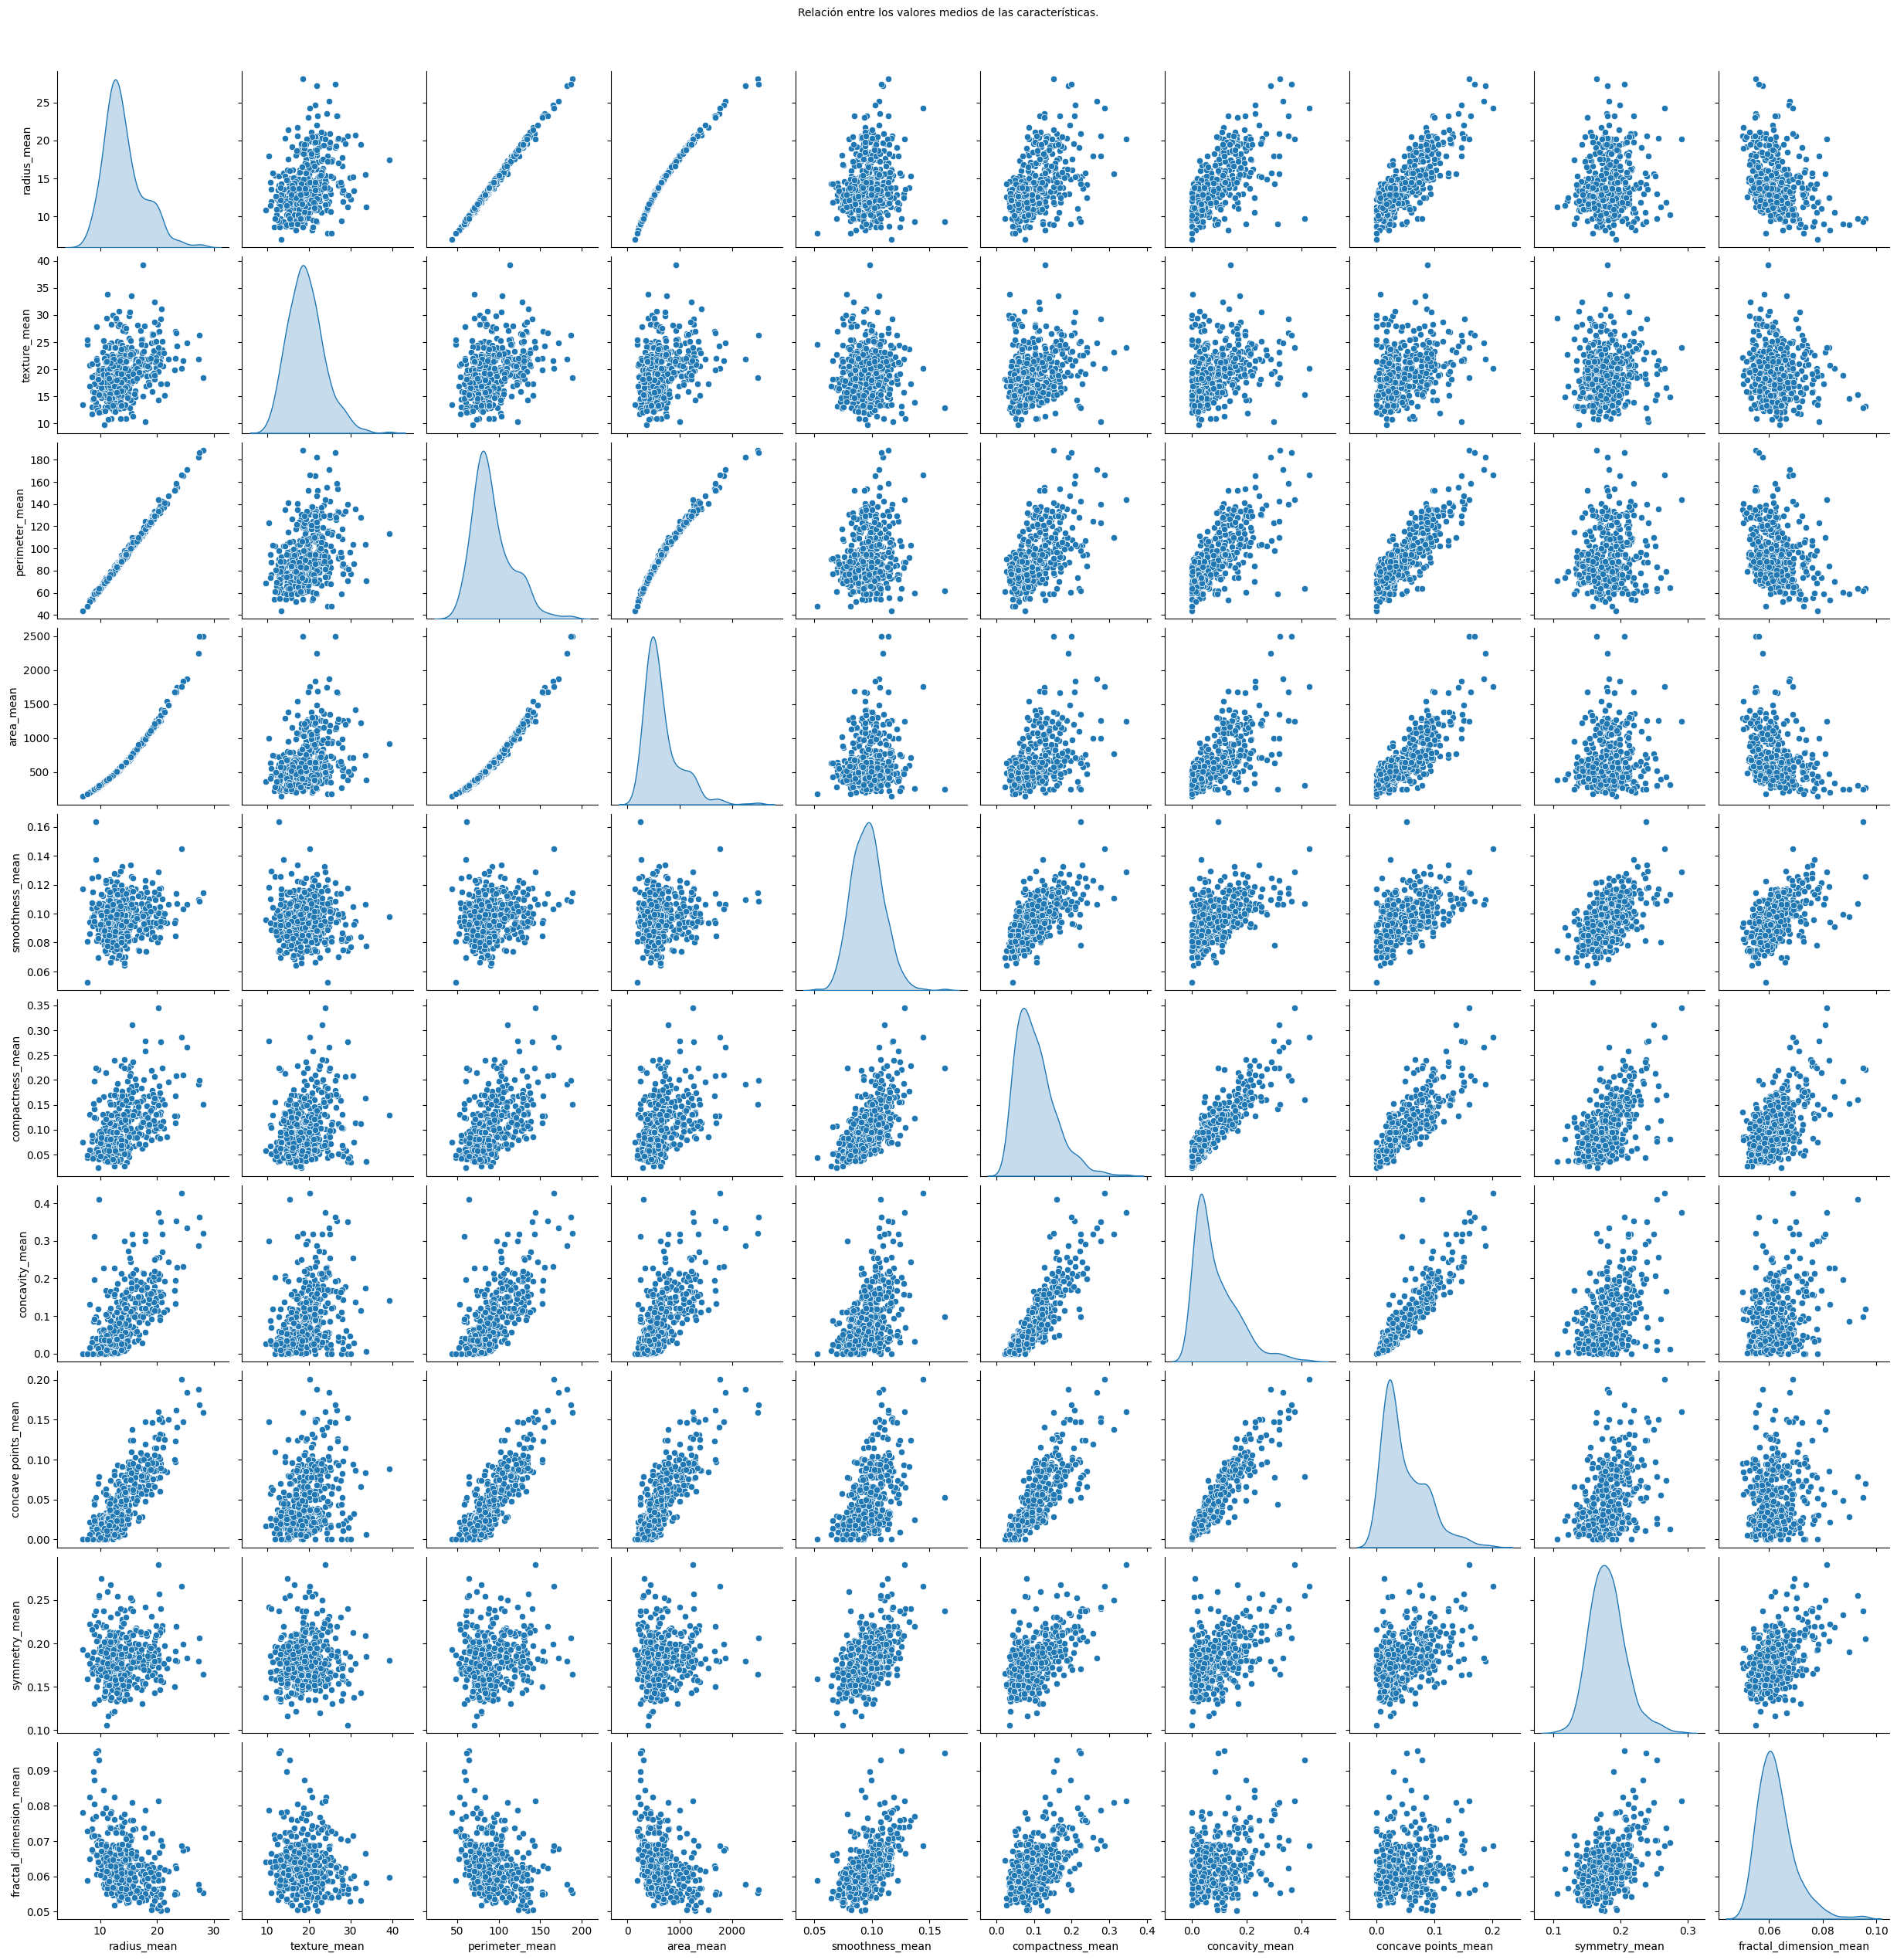

In [40]:
plt.figure(figsize=(12, 12));

g = sns.pairplot(cancer[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean','smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']], diag_kind='kde');
g.fig.suptitle("Relación entre los valores medios de las características.", fontsize=10, y=1.02);

In the scatter plots the correlations between radius, perimeter and area are clearly seen. Also weaker correlations between radii, concave_points and compactness.

To know which columns to keep among the correlated ones, we see the correlation with the target column.


In [31]:
abs(matrix_correlation['diagnosis']).sort_values(ascending=False)

diagnosis                  1.000000
perimeter_worst            0.797044
area_worst                 0.787601
radius_worst               0.786843
concave points_worst       0.784755
concave points_mean        0.777594
perimeter_mean             0.752580
area_mean                  0.740405
radius_mean                0.739023
concavity_mean             0.730657
area_se                    0.713253
concavity_worst            0.700029
perimeter_se               0.628632
compactness_mean           0.608691
radius_se                  0.607948
compactness_worst          0.600528
texture_worst              0.492370
concave points_se          0.490472
concavity_se               0.473488
texture_mean               0.472222
smoothness_worst           0.445538
compactness_se             0.381876
smoothness_mean            0.366693
symmetry_worst             0.364669
symmetry_mean              0.309639
fractal_dimension_worst    0.293122
fractal_dimension_se       0.197121
symmetry_se                0

We then see that among the variables correlated with each other: area, perimeter, radius, 'compactness', 'concave_points' and 'concavity'; the most correlated with the objective is 'perimeter_worst'. So we left that one.

On the other hand, 'perimeter_se', 'radius_se' and 'area_se' have high correlation with 'perimeter_worst', while 'concave points_se', 'compactness_se' have a lower correlation:

In [32]:
abs(matrix_correlation['perimeter_worst']).sort_values(ascending=False)

perimeter_worst            1.000000
radius_worst               0.993532
area_worst                 0.992637
perimeter_mean             0.979822
area_mean                  0.973773
radius_mean                0.973468
concave points_worst       0.811235
concave points_mean        0.809121
diagnosis                  0.797044
area_se                    0.756662
concavity_mean             0.719148
concavity_worst            0.699542
compactness_worst          0.618251
perimeter_se               0.610695
compactness_mean           0.595826
radius_se                  0.569514
concave points_se          0.446039
concavity_se               0.436208
texture_worst              0.409882
texture_mean               0.403608
compactness_se             0.352825
smoothness_se              0.296790
symmetry_se                0.269205
fractal_dimension_mean     0.262417
smoothness_worst           0.259281
symmetry_worst             0.256459
smoothness_mean            0.206587
fractal_dimension_worst    0

Así que de las 18 variables ['area_mean', 'area_se', 'area_worst', 'compactness_mean', 'compactness_se', 'compactness_worst', 'concave points_mean', 'concave points_se', 'concave points_worst', 'concavity_mean', 'concavity_se', 'concavity_worst', 'perimeter_mean', 'perimeter_se', 'perimeter_worst', 'radius_mean', 'radius_se', 'radius_worst'] solo dejamos:

In [33]:
features_1=['perimeter_worst', 'concave points_se', 'compactness_se']

The three columns of fractal_dimension are highly correlated with each other, and are also highly correlated with 'smoothness_mean' and 'smoothness_worst'. So seeing the relationship with the target variable, of these 5 columns we only leave 'smoothness_worst'.

The rest of the deviation columns have no obvious correlation with any of the others, so the rest of the columns we leave are:

In [34]:
features_2=['smoothness_worst', 'symmetry_worst', 'texture_worst', 'smoothness_se', 'symmetry_se', 'texture_se']

In [35]:
features=features_1+features_2

## Preprocessing

In [36]:
X_train=X_train[features]
X_test=X_test[features]

In [37]:
scaler = StandardScaler() 
scaler.fit(X_train) 

X_train_enc=scaler.transform(X_train) #transform training data
X_test_enc=scaler.transform(X_test) #transform validation data

In [38]:
X_train_enc = pd.DataFrame(X_train_enc, columns=X_train.columns, index=X_train.index) # This is the training set encoded.

## Model evaluation

We are going to calculate several metrics to see the comparison between the different models. Although the metric that we are going to consider most important and as a decision criterion is going to be the MCC metric.
 (see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6817921/).